<a href="https://colab.research.google.com/github/NeilMitra/2WD-ObstacleAvoidingRobot/blob/master/Daily_Mover_Adjusted_Plot_Update.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Algorithm

In [ ]:
!pip install pandas numpy yfinance

In [ ]:
# imports

import pandas as pd
import numpy as np
import yfinance as yf
import datetime
import time
import random
import os
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
import warnings
warnings.filterwarnings('ignore')

In [ ]:
def get_top_100_sp500_by_market_cap():
    """
    Get the top 100 S&P 500 stocks by market capitalization with rate limit handling.
    Caches results to avoid repeated API calls.
    """
    cache_file = "sp500_top100_cache.csv"

    # Check if we have a recent cache file (less than 24 hours old)
    if os.path.exists(cache_file) and (datetime.datetime.now() -
            datetime.datetime.fromtimestamp(os.path.getmtime(cache_file))).total_seconds() < 86400:
        print(f"Loading top 100 stocks from cache file: {cache_file}")
        return pd.read_csv(cache_file)['Symbol'].tolist()

    # Get S&P 500 tickers
    sp500_url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
    sp500_table = pd.read_html(sp500_url)[0]
    sp500_symbols = sp500_table['Symbol'].tolist()

    # Get market cap for all symbols with rate limiting
    market_caps = {}
    for i, symbol in enumerate(sp500_symbols):
        try:
            # Add random delay between requests to avoid rate limiting
            if i > 0 and i % 5 == 0:
                delay = random.uniform(1.0, 3.0)
                print(f"Sleeping for {delay:.2f} seconds to avoid rate limiting...")
                time.sleep(delay)

            ticker = yf.Ticker(symbol)
            market_cap = ticker.info.get('marketCap', 0)
            if market_cap:
                market_caps[symbol] = market_cap
                print(f"[{i+1}/{len(sp500_symbols)}] {symbol}: ${market_cap:,}")
            else:
                print(f"[{i+1}/{len(sp500_symbols)}] {symbol}: No market cap data available")
        except Exception as e:
            print(f"[{i+1}/{len(sp500_symbols)}] Error fetching data for {symbol}: {e}")
            # If we hit a rate limit, pause for a longer time
            if "rate limit" in str(e).lower():
                pause_time = random.uniform(10.0, 15.0)
                print(f"Rate limit detected. Pausing for {pause_time:.2f} seconds...")
                time.sleep(pause_time)

    # Sort by market cap and get top 100
    sorted_by_market_cap = sorted(market_caps.items(), key=lambda x: x[1], reverse=True)
    top_100 = [symbol for symbol, _ in sorted_by_market_cap[:100]]

    # Save to cache file
    pd.DataFrame({'Symbol': top_100}).to_csv(cache_file, index=False)
    print(f"Saved top 100 stocks to cache file: {cache_file}")

    return top_100

def get_trading_date(date, calendar):
    """
    Get the nearest trading date for a given date.
    If date is a weekend or holiday, return the previous trading day.
    """
    us_bd = CustomBusinessDay(calendar=calendar)
    dt = pd.Timestamp(date)

    # If it's a business day, return the date
    if dt in calendar:
        return dt

    # Otherwise, return the previous business day
    return dt - us_bd

def analyze_date_patterns(tickers, years=10):
    """
    Analyze date patterns for a list of ticker symbols over a specified number of years.
    Implements caching and rate limit handling.

    Parameters:
    tickers (list): List of ticker symbols
    years (int): Number of years to analyze

    Returns:
    tuple: (up_patterns, down_patterns) where each is a dictionary mapping dates to stocks
    """
    # Create directory for cached data
    cache_dir = "stock_data_cache"
    if not os.path.exists(cache_dir):
        os.makedirs(cache_dir)

    # Create a calendar for US trading days
    cal = USFederalHolidayCalendar()
    holidays = cal.holidays(start=datetime.datetime.now() - datetime.timedelta(days=years*365),
                           end=datetime.datetime.now())

    # Initialize pattern dictionaries
    up_patterns = {}  # date -> [symbols that consistently go up]
    down_patterns = {}  # date -> [symbols that consistently go down]

    # Get current date
    now = datetime.datetime.now()

    # For each ticker, get historical data and analyze patterns
    for i, ticker in enumerate(tickers):
        print(f"[{i+1}/{len(tickers)}] Analyzing {ticker}...")

        try:
            # Define cache file path
            cache_file = os.path.join(cache_dir, f"{ticker}_data.csv")

            # Check if we have cached data and it's recent (less than 24 hours old)
            if os.path.exists(cache_file) and (datetime.datetime.now() -
                    datetime.datetime.fromtimestamp(os.path.getmtime(cache_file))).total_seconds() < 86400:
                print(f"  Loading cached data for {ticker}")
                historical_data = pd.read_csv(cache_file, index_col=0, parse_dates=True)
            else:
                # Implement rate limiting - add delay between batches of requests
                if i > 0 and i % 3 == 0:
                    delay = random.uniform(2.0, 5.0)
                    print(f"  Sleeping for {delay:.2f} seconds to avoid rate limiting...")
                    time.sleep(delay)

                # Get historical data for the past 'years' years
                start_date = (now - datetime.timedelta(days=years*365)).strftime('%Y-%m-%d')
                print(f"  Downloading data for {ticker} from {start_date} to now...")

                # Try with exponential backoff for rate limiting
                max_retries = 5
                retry_count = 0
                backoff_time = 1

                while retry_count < max_retries:
                    try:
                        historical_data = yf.download(ticker, start=start_date, progress=False)
                        break
                    except Exception as e:
                        if "rate limit" in str(e).lower() or "connection" in str(e).lower():
                            retry_count += 1
                            if retry_count >= max_retries:
                                raise Exception(f"Max retries exceeded for {ticker}")

                            backoff_time *= 2  # Exponential backoff
                            wait_time = backoff_time + random.uniform(0, 1)
                            print(f"  Rate limit hit. Retry {retry_count}/{max_retries}. Waiting {wait_time:.2f} seconds...")
                            time.sleep(wait_time)
                        else:
                            raise

                # Save to cache
                historical_data.to_csv(cache_file)
                print(f"  Saved data to cache: {cache_file}")

            if historical_data.empty:
                print(f"  No data available for {ticker}")
                continue

            # Create month-day column for grouping
            historical_data['month_day'] = historical_data.index.strftime('%m-%d')

            # Calculate daily returns
            if 'return' not in historical_data.columns:
                historical_data['return'] = historical_data['Close'].pct_change()

            # Group by month-day and analyze patterns
            for month_day, group in historical_data.groupby('month_day'):
                if len(group) >= years/2:  # Require at least half of the possible years to have data
                    positive_returns = (group['return'] > 0).sum()
                    total_returns = (~group['return'].isna()).sum()

                    # If stock goes up on this date at least 80% of the time
                    if total_returns > 0 and positive_returns / total_returns >= 0.8:
                        if month_day not in up_patterns:
                            up_patterns[month_day] = []
                        up_patterns[month_day].append((ticker, positive_returns, total_returns))

                    # If stock goes down on this date at least 80% of the time
                    if total_returns > 0 and positive_returns / total_returns <= 0.2:
                        if month_day not in down_patterns:
                            down_patterns[month_day] = []
                        down_patterns[month_day].append((ticker, total_returns - positive_returns, total_returns))

        except Exception as e:
            print(f"  Error analyzing {ticker}: {e}")

            # If we hit a rate limit or connection error, pause for longer
            if "rate limit" in str(e).lower() or "connection" in str(e).lower():
                pause_time = random.uniform(15.0, 30.0)
                print(f"  Rate limit or connection issue detected. Pausing for {pause_time:.2f} seconds...")
                time.sleep(pause_time)

    return up_patterns, down_patterns

def format_results(patterns, pattern_type):
    """
    Format pattern results for display.

    Parameters:
    patterns (dict): Dictionary mapping dates to stocks with patterns
    pattern_type (str): "UP" or "DOWN"

    Returns:
    DataFrame: Formatted results
    """
    results = []

    for date, stocks in patterns.items():
        for stock, matches, total in stocks:
            month, day = date.split('-')
            current_year = datetime.datetime.now().year

            # Create a list of dates for the past 10 years on which this pattern occurs
            historical_dates = []
            for year in range(current_year - 10, current_year + 1):
                try:
                    pattern_date = datetime.datetime(year, int(month), int(day))
                    day_of_week = pattern_date.strftime('%A')

                    # Check if it's a weekend
                    is_weekend = day_of_week in ['Saturday', 'Sunday']

                    historical_dates.append(f"{pattern_date.strftime('%Y-%m-%d')} ({day_of_week}){' - Weekend' if is_weekend else ''}")
                except ValueError:
                    # Skip invalid dates (e.g., February 29 in non-leap years)
                    pass

            results.append({
                'Stock': stock,
                'Pattern Date': date,
                'Pattern Type': pattern_type,
                'Success Rate': f"{matches}/{total} ({(matches/total)*100:.1f}%)",
                'Historical Dates': ', '.join(historical_dates)
            })

    if results:
        return pd.DataFrame(results)
    else:
        return pd.DataFrame(columns=['Stock', 'Pattern Date', 'Pattern Type', 'Success Rate', 'Historical Dates'])

def main():
    """
    Main function to run the stock date pattern screener.
    """
    print("==== Stock Date Pattern Screener ====")
    print("This script uses caching to minimize API requests and avoid rate limiting.")

    # Allow for batch mode to process stocks in smaller batches
    batch_size = 10  # Process 10 stocks at a time

    print("\nGetting top 100 S&P 500 stocks by market cap...")
    top_100_stocks = get_top_100_sp500_by_market_cap()
    print(f"Retrieved {len(top_100_stocks)} stocks.")

    # Process in batches to avoid rate limiting
    all_up_patterns = {}
    all_down_patterns = {}

    for i in range(0, len(top_100_stocks), batch_size):
        batch = top_100_stocks[i:i+batch_size]
        print(f"\nProcessing batch {i//batch_size + 1}/{(len(top_100_stocks) + batch_size - 1)//batch_size}")
        print(f"Analyzing date patterns for stocks {i+1}-{min(i+batch_size, len(top_100_stocks))} of {len(top_100_stocks)}...")

        up_patterns, down_patterns = analyze_date_patterns(batch)

        # Merge results
        for date, stocks in up_patterns.items():
            if date not in all_up_patterns:
                all_up_patterns[date] = []
            all_up_patterns[date].extend(stocks)

        for date, stocks in down_patterns.items():
            if date not in all_down_patterns:
                all_down_patterns[date] = []
            all_down_patterns[date].extend(stocks)

        # Save intermediate results
        print("Saving intermediate results...")
        intermediate_up = format_results(all_up_patterns, "UP")
        intermediate_down = format_results(all_down_patterns, "DOWN")

        intermediate_results = pd.concat([intermediate_up, intermediate_down]).reset_index(drop=True)
        if not intermediate_results.empty:
            intermediate_results.to_csv(f"stock_date_patterns_batch_{i//batch_size + 1}.csv", index=False)

        # Wait between batches to avoid rate limiting
        if i + batch_size < len(top_100_stocks):
            delay = random.uniform(5.0, 10.0)
            print(f"Waiting {delay:.2f} seconds before processing next batch...")
            time.sleep(delay)

    print("\nFormatting final results...")
    up_results = format_results(all_up_patterns, "UP")
    down_results = format_results(all_down_patterns, "DOWN")

    # Combine results
    all_results = pd.concat([up_results, down_results]).reset_index(drop=True)

    # Sort by pattern date
    all_results = all_results.sort_values(['Pattern Date', 'Stock']).reset_index(drop=True)

    print("\nTop date patterns found:")
    if not all_results.empty:
        # Print top 10 most consistent patterns
        display_results = all_results.copy()
        display_results['Success Rate Numeric'] = display_results['Success Rate'].apply(
            lambda x: float(x.split('(')[1].split('%')[0])
        )
        display_results = display_results.sort_values('Success Rate Numeric', ascending=False).head(10)
        display_results = display_results.drop('Success Rate Numeric', axis=1)
        print(display_results)

        # Save results to CSV
        output_file = "stock_date_patterns_final.csv"
        all_results.to_csv(output_file, index=False)
        print(f"\nFull results saved to {output_file}")
    else:
        print("No significant patterns found.")

    print("\nAnalysis complete!")

if __name__ == "__main__":
    main()

==== Stock Date Pattern Screener ====
This script uses caching to minimize API requests and avoid rate limiting.

Getting top 100 S&P 500 stocks by market cap...
[1/503] MMM: $79,689,629,696
[2/503] AOS: $9,490,137,088
[3/503] ABT: $228,808,818,688
[4/503] ABBV: $362,977,001,472
[5/503] ACN: $198,169,968,640
Sleeping for 1.96 seconds to avoid rate limiting...
[6/503] ADBE: $164,419,436,544
[7/503] AMD: $167,271,907,328
[8/503] AES: $8,884,524,032
[9/503] AFL: $61,278,646,272
[10/503] A: $33,069,096,960
Sleeping for 1.60 seconds to avoid rate limiting...
[11/503] APD: $65,621,520,384
[12/503] ABNB: $76,300,558,336
[13/503] AKAM: $12,270,457,856
[14/503] ALB: $8,500,284,928
[15/503] ARE: $15,981,584,384
Sleeping for 1.48 seconds to avoid rate limiting...
[16/503] ALGN: $12,068,534,272
[17/503] ALLE: $11,403,276,288
[18/503] LNT: $16,565,738,496
[19/503] ALL: $54,444,290,048
[20/503] GOOGL: $1,924,258,070,528
Sleeping for 1.05 seconds to avoid rate limiting...
[21/503] GOOG: $1,924,398,31

# Backtesting

Starting backtest with $100,000.00 from 2013 to 2023
Loading historical data for 10 stocks...
  Loading cached data for BAC
  Successfully loaded data for BAC with 2811 data points
  No data available for RTN
  No data available for UTX
  Loading cached data for RTX
  Successfully loaded data for RTX with 2811 data points
  Loading cached data for FIS
  Loading cached data for FI
  Successfully loaded data for FI with 2811 data points
  Loading cached data for COP
  Successfully loaded data for COP with 2811 data points
  Loading cached data for INTU
  Successfully loaded data for INTU with 2811 data points
  Loading cached data for CVX
  Successfully loaded data for CVX with 2811 data points
  Loading cached data for MRK
  Successfully loaded data for MRK with 2811 data points
  Loading cached data for SCHW
  Successfully loaded data for SCHW with 2811 data points
  Loading cached data for C
  Successfully loaded data for C with 2811 data points
  Loading cached data for MCD
  Success

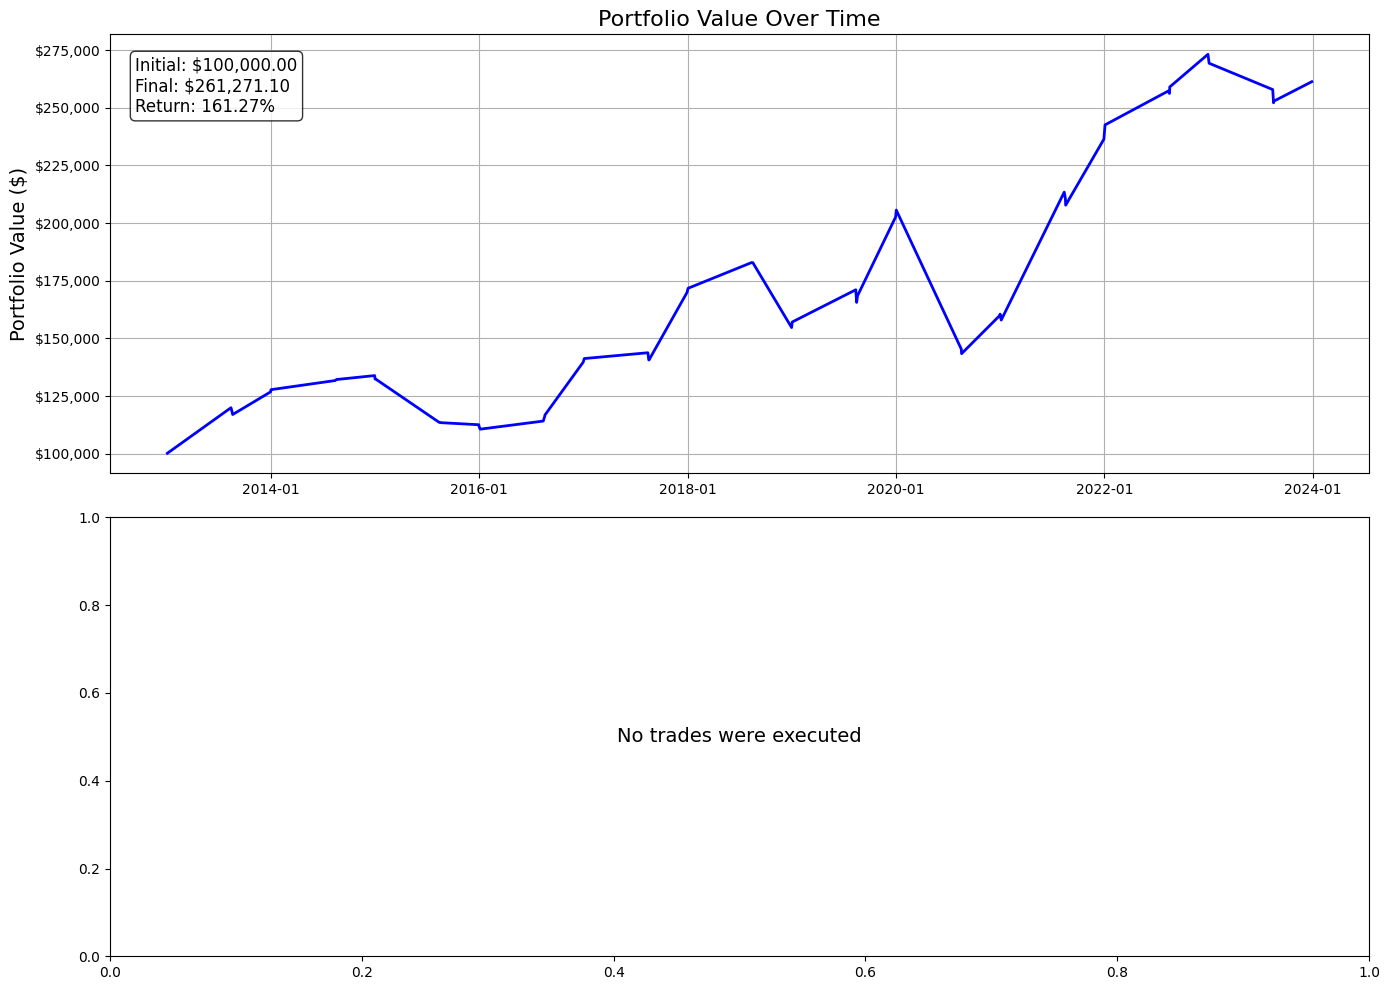

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from matplotlib.ticker import FuncFormatter
import os
import time
import warnings
import logging
logging.getLogger('yfinance').setLevel(logging.CRITICAL)

warnings.filterwarnings('ignore')

class PatternBacktester:
    def __init__(self, initial_capital=100000):
        """
        Initialize the backtester with patterns identified in the screening phase.

        Parameters:
        initial_capital (float): Initial capital to invest
        """
        self.initial_capital = initial_capital
        self.current_capital = initial_capital
        self.portfolio_value_history = []
        self.date_history = []
        self.stock_value_history = {}

        # Create a calendar for US trading days
        self.calendar = USFederalHolidayCalendar()
        self.holidays = self.calendar.holidays(start=datetime.datetime(2010, 1, 1),
                                              end=datetime.datetime(2025, 12, 31))
        self.business_day = CustomBusinessDay(calendar=self.calendar)

        # Define pattern stocks based on the output
        self.up_patterns = {
            '01-02': ['BAC', 'COP', 'CVX', 'RTX'],
            '08-13': ['FI', 'MRK']
        }

        self.down_patterns = {
            '08-17': ['SCHW'],
            '08-18': ['C'],
            '12-30': ['INTU', 'MCD']
        }

        # Handle ticker symbol changes
        self.ticker_mappings = {
            'RTX': ['RTN', 'UTX', 'RTX'],  # Raytheon merged with United Technologies
            'FI': ['FIS', 'FI']            # Fidelity National Information Services
        }

        # Store historical data for each stock
        self.stock_data = {}

        # Track positions
        self.positions = {}  # symbol -> quantity
        self.position_history = {}  # date -> positions dict

        # Create cache directory
        self.cache_dir = "backtest_data_cache"
        if not os.path.exists(self.cache_dir):
            os.makedirs(self.cache_dir)

        # Trading day window (days to look before/after a pattern date)
        self.trading_day_window = 3

        # Track trade history
        self.trade_history = []

        # All trading days in the dataset
        self.all_trading_days = []

    def is_trading_day(self, date):
        """
        Check if a date is a trading day (not weekend or holiday).

        Parameters:
        date (datetime): Date to check

        Returns:
        bool: True if trading day, False otherwise
        """
        return (date.weekday() < 5) and (date not in self.holidays)

    def find_closest_trading_day(self, target_date, max_days=3):
        """
        Find the closest trading day to the target date within a window.
        Prioritizes exact date, then next trading day, then previous trading day.

        Parameters:
        target_date (datetime): Target date
        max_days (int): Maximum days to look before/after

        Returns:
        datetime or None: Closest trading day or None if not found
        """
        # First check the exact date
        if self.is_trading_day(target_date):
            return target_date

        # Look forward and backward in a window
        for offset in range(1, max_days + 1):
            # Check future date
            future_date = target_date + datetime.timedelta(days=offset)
            if self.is_trading_day(future_date):
                return future_date

            # Check past date
            past_date = target_date - datetime.timedelta(days=offset)
            if self.is_trading_day(past_date):
                return past_date

        return None

    def load_stock_data(self, start_date, end_date):
        """
        Load historical data for all stocks in the patterns.

        Parameters:
        start_date (str): Start date in YYYY-MM-DD format
        end_date (str): End date in YYYY-MM-DD format
        """
        # Collect all unique stocks from both up and down patterns
        all_stocks = set()
        for stocks in self.up_patterns.values():
            all_stocks.update(stocks)
        for stocks in self.down_patterns.values():
            all_stocks.update(stocks)

        print(f"Loading historical data for {len(all_stocks)} stocks...")

        # Process each stock
        for i, symbol in enumerate(all_stocks):
            # Handle ticker mappings (historical changes)
            symbols_to_try = self.ticker_mappings.get(symbol, [symbol])

            data_frames = []
            for ticker in symbols_to_try:
                cache_file = os.path.join(self.cache_dir, f"{ticker}_data.csv")

                # Check if we have cached data
                if os.path.exists(cache_file):
                    print(f"  Loading cached data for {ticker}")
                    try:
                        df = pd.read_csv(cache_file, index_col=0, parse_dates=True)
                        if not df.empty:
                            data_frames.append(df)
                    except Exception as e:
                        print(f"  Error loading cached data for {ticker}: {e}")
                else:
                    print(f"  Downloading data for {ticker} ({i+1}/{len(all_stocks)})...")

                    # Add a small delay to avoid rate limiting
                    if i > 0:
                        time.sleep(np.random.uniform(1.0, 2.0))

                    try:
                        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
                        if not df.empty:
                            data_frames.append(df)
                            # Save to cache
                            df.to_csv(cache_file)
                        else:
                            print(f"  No data available for {ticker}")
                    except Exception as e:
                        print(f"  Error downloading data for {ticker}: {e}")

            # Combine data frames if we have more than one
            if len(data_frames) > 0:
                if len(data_frames) > 1:
                    # Combine data from different ticker symbols (for changes over time)
                    combined_df = pd.concat(data_frames)
                    # Sort by date and remove duplicates
                    combined_df = combined_df.sort_index().loc[~combined_df.index.duplicated(keep='first')]
                else:
                    combined_df = data_frames[0]

                self.stock_data[symbol] = combined_df
                print(f"  Successfully loaded data for {symbol} with {len(combined_df)} data points")

                # Collect trading days
                self.all_trading_days.extend(combined_df.index.tolist())

        # Remove duplicates and sort trading days
        self.all_trading_days = sorted(list(set(self.all_trading_days)))
        print(f"Loaded {len(self.all_trading_days)} trading days.")

    def get_price_on_date(self, symbol, date, price_type='Open', window_days=3):
      """
      Improved version that directly inspects and accesses dataframe contents
      """
      if symbol not in self.stock_data:
          return None, None

      stock_df = self.stock_data[symbol]

      # Print diagnostic information for debugging
      print(f"DEBUG: Looking for {symbol} price on {date}")
      print(f"DEBUG: First few dates in dataframe: {stock_df.index[:5]}")

      # Handle exact date match with better error handling
      if date in stock_df.index:
          try:
              if isinstance(stock_df.loc[date, price_type], pd.Series):
                  price = stock_df.loc[date, price_type].iloc[0]
              else:
                  price = stock_df.loc[date, price_type]

              if not pd.isna(price):
                  return float(price), date
          except Exception as e:
              print(f"DEBUG: Error accessing exact date: {e}")

      # Try alternative methods to find the date in the index
      try:
          # Convert date to string format and look for match
          date_str = date.strftime('%Y-%m-%d')
          matching_dates = [d for d in stock_df.index if str(d).startswith(date_str)]
          if matching_dates:
              price = stock_df.loc[matching_dates[0], price_type]
              if isinstance(price, pd.Series):
                  price = price.iloc[0]
              if not pd.isna(price):
                  return float(price), matching_dates[0]
      except Exception as e:
          print(f"DEBUG: Error with string matching: {e}")

      # Look within a window (up to window_days in both directions)
      for offset in range(1, window_days + 1):
          # Try future date
          future_date = date + datetime.timedelta(days=offset)
          if future_date in stock_df.index:
              try:
                  price = stock_df.loc[future_date, price_type]
                  if isinstance(price, pd.Series):
                      price = price.iloc[0]
                  if not pd.isna(price):
                      return float(price), future_date
              except:
                  pass

          # Try past date
          past_date = date - datetime.timedelta(days=offset)
          if past_date in stock_df.index:
              try:
                  price = stock_df.loc[past_date, price_type]
                  if isinstance(price, pd.Series):
                      price = price.iloc[0]
                  if not pd.isna(price):
                      return float(price), past_date
              except:
                  pass

      # Direct inspection of nearby dates as a last resort
      try:
          # Find the closest date in the index
          date_as_timestamp = pd.Timestamp(date)
          closest_idx = (stock_df.index - date_as_timestamp).abs().argmin()
          closest_date = stock_df.index[closest_idx]

          # Check if it's within our window
          days_diff = abs((closest_date - date_as_timestamp).days)
          if days_diff <= window_days:
              price = stock_df.loc[closest_date, price_type]
              if isinstance(price, pd.Series):
                  price = price.iloc[0]
              if not pd.isna(price):
                  return float(price), closest_date
      except Exception as e:
          print(f"DEBUG: Error with closest date approach: {e}")

      return None, None

    def run_backtest(self, start_year=2013, end_year=2023):
        """
        Run the backtest simulation.

        Parameters:
        start_year (int): Start year for the backtest
        end_year (int): End year for the backtest

        Returns:
        float: Final portfolio value
        """
        # Load stock data
        start_date = f"{start_year-1}-12-01"  # Start a month early for first trades
        end_date = f"{end_year+1}-02-01"  # End a month late for last trades
        self.load_stock_data(start_date, end_date)

        # Initialize portfolio and capital
        self.current_capital = self.initial_capital
        self.portfolio_value_history = []
        self.date_history = []
        self.positions = {}
        self.position_history = {}
        self.trade_history = []

        # Initialize stock value history
        for pattern_type in ['UP', 'DOWN']:
            for date, stocks in (self.up_patterns.items() if pattern_type == 'UP' else self.down_patterns.items()):
                for stock in stocks:
                    self.stock_value_history[f"{stock}_{pattern_type}"] = []

        # Run the backtest for each year
        for year in range(start_year, end_year + 1):
            print(f"\nBacktesting year {year}...")

            # Execute trades for each pattern date in this year
            for month_day, stocks in self.up_patterns.items():
                month, day = map(int, month_day.split('-'))
                pattern_date = datetime.datetime(year, month, day)
                trading_day = self.find_closest_trading_day(pattern_date, self.trading_day_window)

                if trading_day:
                    print(f"  Processing UP pattern on {month_day} (actual trading day: {trading_day.strftime('%Y-%m-%d')})")
                    self.execute_trades(trading_day, stocks, 'UP')
                else:
                    print(f"  No suitable trading day found for {month_day} in {year}")

            for month_day, stocks in self.down_patterns.items():
                month, day = map(int, month_day.split('-'))
                pattern_date = datetime.datetime(year, month, day)
                trading_day = self.find_closest_trading_day(pattern_date, self.trading_day_window)

                if trading_day:
                    print(f"  Processing DOWN pattern on {month_day} (actual trading day: {trading_day.strftime('%Y-%m-%d')})")
                    self.execute_trades(trading_day, stocks, 'DOWN')
                else:
                    print(f"  No suitable trading day found for {month_day} in {year}")

            # Record portfolio value at end of year
            year_end = datetime.datetime(year, 12, 31)
            if self.is_trading_day(year_end):
                trading_day = year_end
            else:
                # Find last trading day of the year
                trading_day = self.find_closest_trading_day(year_end, 10)
                if not trading_day or trading_day.year != year:
                    # If no trading day found in a 10-day window, get the last trading day of Dec
                    for day in range(30, 0, -1):
                        test_date = datetime.datetime(year, 12, day)
                        if self.is_trading_day(test_date):
                            trading_day = test_date
                            break

            if trading_day:
                portfolio_value = self.calculate_portfolio_value(trading_day)
                self.date_history.append(trading_day)
                self.portfolio_value_history.append(portfolio_value)
                print(f"  Year-end portfolio value ({trading_day.strftime('%Y-%m-%d')}): ${portfolio_value:,.2f}")

        # Calculate final portfolio value and close all positions
        final_date = datetime.datetime(end_year, 12, 31)
        trading_day = self.find_closest_trading_day(final_date, 10)

        if trading_day:
            self.close_positions(trading_day)
            final_value = self.current_capital
        else:
            final_value = self.current_capital

        # Calculate performance metrics
        total_return = (final_value / self.initial_capital - 1) * 100
        annual_return = ((final_value / self.initial_capital) ** (1 / (end_year - start_year + 1)) - 1) * 100

        print(f"\nBacktest Results ({start_year}-{end_year}):")
        print(f"Initial Capital: ${self.initial_capital:,.2f}")
        print(f"Final Portfolio Value: ${final_value:,.2f}")
        print(f"Total Return: {total_return:.2f}%")
        print(f"Annual Return: {annual_return:.2f}%")

        # Print trade summary
        if self.trade_history:
            print(f"\nTotal trades executed: {len(self.trade_history)}")
            profitable_trades = sum(1 for trade in self.trade_history if trade['profit'] > 0)
            if len(self.trade_history) > 0:
                win_rate = (profitable_trades / len(self.trade_history)) * 100
                print(f"Win rate: {win_rate:.2f}% ({profitable_trades}/{len(self.trade_history)})")
        else:
            print("\nNo trades were executed during the backtest period.")

        return final_value

    def execute_trades(self, date, symbols, pattern_type):
        """
        Execute trades based on the patterns.

        Parameters:
        date (datetime): Trading date
        symbols (list): List of stock symbols
        pattern_type (str): 'UP' or 'DOWN'
        """
        # Close any existing positions first
        self.close_positions(date)

        valid_symbols = []
        for symbol in symbols:
            price, actual_date = self.get_price_on_date(symbol, date, 'Open')
            if price is not None:
                valid_symbols.append((symbol, price, actual_date))

        if not valid_symbols:
            print(f"    No valid price data found for any {pattern_type} pattern stocks on {date.strftime('%Y-%m-%d')}")
            return

        # Calculate amount to invest per stock
        amount_per_stock = self.current_capital / len(valid_symbols)

        for symbol, price, actual_date in valid_symbols:
            try:
                # Calculate quantity based on price
                quantity = int(amount_per_stock / price)

                if quantity <= 0:
                    print(f"    Skipping {symbol}: calculated quantity is {quantity} (price: ${price:.2f})")
                    continue

                cost = quantity * price
                entry_info = {
                    'date': actual_date,
                    'symbol': symbol,
                    'price': price,
                    'quantity': quantity if pattern_type == 'UP' else -quantity,  # Negative for short
                    'cost': cost,
                    'pattern_type': pattern_type
                }

                # Record the position
                self.positions[symbol] = entry_info['quantity']

                # Update capital
                self.current_capital -= cost

                # Generate trade entry message
                if pattern_type == 'UP':
                    print(f"    BOUGHT {quantity} shares of {symbol} at ${price:.2f} on {actual_date.strftime('%Y-%m-%d')}")
                else:
                    print(f"    SHORTED {quantity} shares of {symbol} at ${price:.2f} on {actual_date.strftime('%Y-%m-%d')}")

                # Track the trade
                self.trade_history.append({
                    'entry_date': actual_date,
                    'symbol': symbol,
                    'pattern_type': pattern_type,
                    'entry_price': price,
                    'quantity': entry_info['quantity'],
                    'exit_date': None,
                    'exit_price': None,
                    'profit': None
                })

            except Exception as e:
                print(f"    Error executing trade for {symbol}: {e}")

        # Update portfolio value history
        portfolio_value = self.calculate_portfolio_value(date)
        if date not in self.date_history:
            self.date_history.append(date)
            self.portfolio_value_history.append(portfolio_value)

    def close_positions(self, date):
        """
        Close all current positions.

        Parameters:
        date (datetime): Date to close positions

        Returns:
        float: Total profit/loss from closing positions
        """
        if not self.positions:
            return 0

        total_profit_loss = 0

        for symbol, quantity in list(self.positions.items()):
            price, actual_date = self.get_price_on_date(symbol, date, 'Open')

            if price is None:
                print(f"    Cannot close position for {symbol}: no valid price data found")
                continue

            try:
                # Calculate profit/loss
                position_value = abs(quantity) * price

                # Generate trade exit message
                if quantity > 0:  # Long position
                    print(f"    SOLD {quantity} shares of {symbol} at ${price:.2f} on {actual_date.strftime('%Y-%m-%d')}")
                else:  # Short position
                    print(f"    COVERED {abs(quantity)} shares of {symbol} at ${price:.2f} on {actual_date.strftime('%Y-%m-%d')}")

                # Update capital
                self.current_capital += position_value
                total_profit_loss += position_value

                # Find corresponding entry in trade history
                for trade in reversed(self.trade_history):
                    if trade['symbol'] == symbol and trade['exit_date'] is None:
                        trade['exit_date'] = actual_date
                        trade['exit_price'] = price

                        # Calculate profit based on position type
                        if trade['pattern_type'] == 'UP':  # Long position
                            trade['profit'] = (price - trade['entry_price']) * abs(trade['quantity'])
                        else:  # Short position
                            trade['profit'] = (trade['entry_price'] - price) * abs(trade['quantity'])

                        print(f"    Trade profit: ${trade['profit']:.2f}")
                        break

                # Remove position
                del self.positions[symbol]

            except Exception as e:
                print(f"    Error closing position for {symbol}: {e}")

        print(f"    Closed all positions with total value: ${total_profit_loss:,.2f}")
        return total_profit_loss

    def calculate_portfolio_value(self, date):
        """
        Calculate the total portfolio value on the current date.

        Parameters:
        date (datetime): Current date

        Returns:
        float: Total portfolio value
        """
        portfolio_value = self.current_capital

        for symbol, quantity in self.positions.items():
            price, _ = self.get_price_on_date(symbol, date, 'Close')

            if price is not None:
                position_value = abs(quantity) * price
                portfolio_value += position_value

        return portfolio_value

    def plot_results(self):
        """
        Plot the backtest results.
        """
        if not self.date_history or not self.portfolio_value_history:
            print("No data to plot.")
            return

        # Create a figure with multiple subplots
        fig = plt.figure(figsize=(14, 10))

        # Portfolio value over time
        ax1 = fig.add_subplot(2, 1, 1)
        ax1.plot(self.date_history, self.portfolio_value_history, 'b-', linewidth=2)
        ax1.set_title('Portfolio Value Over Time', fontsize=16)
        ax1.set_ylabel('Portfolio Value ($)', fontsize=14)
        ax1.grid(True)
        ax1.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

        # Format y-axis to show dollar values
        def money_formatter(x, pos):
            return '${:,.0f}'.format(x)

        ax1.yaxis.set_major_formatter(FuncFormatter(money_formatter))

        # Add initial and final values as text
        if self.portfolio_value_history:
            initial_value = self.initial_capital
            final_value = self.portfolio_value_history[-1]
            total_return = (final_value / initial_value - 1) * 100

            # Add text annotations
            text = (f"Initial: ${initial_value:,.2f}\n"
                   f"Final: ${final_value:,.2f}\n"
                   f"Return: {total_return:.2f}%")

            # Position text at top left
            ax1.text(0.02, 0.95, text, transform=ax1.transAxes, fontsize=12,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

        # Trade profitability
        ax2 = fig.add_subplot(2, 1, 2)

        if self.trade_history:
            # Extract trade profits and dates
            profits = [trade['profit'] for trade in self.trade_history if trade['profit'] is not None]
            dates = [trade['exit_date'] for trade in self.trade_history if trade['exit_date'] is not None]
            patterns = [trade['pattern_type'] for trade in self.trade_history if trade['profit'] is not None]

            if profits and dates:
                # Create colors based on pattern type
                colors = ['green' if p == 'UP' else 'red' for p in patterns]

                # Plot individual trade profits
                ax2.bar(dates, profits, color=colors, alpha=0.7)
                ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
                ax2.set_title('Trade Profitability', fontsize=16)
                ax2.set_ylabel('Profit/Loss ($)', fontsize=14)
                ax2.grid(True, axis='y')
                ax2.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))

                # Format y-axis to show dollar values
                ax2.yaxis.set_major_formatter(FuncFormatter(money_formatter))

                # Add legend
                import matplotlib.patches as mpatches
                up_patch = mpatches.Patch(color='green', label='UP Patterns')
                down_patch = mpatches.Patch(color='red', label='DOWN Patterns')
                ax2.legend(handles=[up_patch, down_patch], loc='upper right')

                # Add trade statistics
                profitable_trades = sum(1 for p in profits if p > 0)
                total_trades = len(profits)
                win_rate = (profitable_trades / total_trades) * 100 if total_trades > 0 else 0

                text = (f"Total Trades: {total_trades}\n"
                       f"Win Rate: {win_rate:.2f}%\n"
                       f"Avg Profit: ${np.mean(profits):.2f}")

                ax2.text(0.02, 0.95, text, transform=ax2.transAxes, fontsize=12,
                        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
            else:
                ax2.text(0.5, 0.5, "No completed trades to display",
                        horizontalalignment='center', verticalalignment='center',
                        transform=ax2.transAxes, fontsize=14)
        else:
            ax2.text(0.5, 0.5, "No trades were executed",
                    horizontalalignment='center', verticalalignment='center',
                    transform=ax2.transAxes, fontsize=14)

        # Adjust layout
        plt.tight_layout()
        plt.savefig('backtest_results.png', dpi=300, bbox_inches='tight')
        plt.show()

    def generate_detailed_report(self):
        """
        Generate a detailed report of the backtest results.
        """
        print("\n============= DETAILED BACKTEST REPORT =============\n")

        # Yearly performance
        print("Yearly Performance:")
        years = sorted(set(d.year for d in self.date_history))

        for year in years:
            year_dates = [i for i, d in enumerate(self.date_history) if d.year == year]
            if year_dates:
                first_idx = min(year_dates)
                last_idx = max(year_dates)

                if first_idx < len(self.portfolio_value_history) and last_idx < len(self.portfolio_value_history):
                    start_value = self.portfolio_value_history[first_idx]
                    end_value = self.portfolio_value_history[last_idx]
                    year_return = (end_value / start_value - 1) * 100
                    print(f"  {year}: {year_return:+.2f}%")

        # Trade performance by pattern
        if self.trade_history:
            # Group trades by pattern
            pattern_performance = {}

            for trade in self.trade_history:
                if trade['profit'] is not None:
                    key = f"{trade['symbol']}_{trade['pattern_type']}"
                    if key not in pattern_performance:
                        pattern_performance[key] = {
                            'symbol': trade['symbol'],
                            'pattern_type': trade['pattern_type'],
                            'total_profit': 0,
                            'win_count': 0,
                            'loss_count': 0,
                            'total_trades': 0
                        }

                    pattern_performance[key]['total_profit'] += trade['profit']
                    pattern_performance[key]['total_trades'] += 1

                    if trade['profit'] > 0:
                        pattern_performance[key]['win_count'] += 1
                    else:
                        pattern_performance[key]['loss_count'] += 1

            # Print top performing patterns
            print("\nTop Performing UP Patterns:")
            up_patterns = {k: v for k, v in pattern_performance.items() if v['pattern_type'] == 'UP'}
            for key, stats in sorted(up_patterns.items(), key=lambda x: x[1]['total_profit'], reverse=True):
                if stats['total_trades'] > 0:
                    win_rate = (stats['win_count'] / stats['total_trades']) * 100
                    print(f"  {stats['symbol']}: ${stats['total_profit']:.2f} (Win Rate: {win_rate:.2f}%, Trades: {stats['total_trades']})")

            print("\nTop Performing DOWN Patterns:")
            down_patterns = {k: v for k, v in pattern_performance.items() if v['pattern_type'] == 'DOWN'}
            for key, stats in sorted(down_patterns.items(), key=lambda x: x[1]['total_profit'], reverse=True):
                if stats['total_trades'] > 0:
                    win_rate = (stats['win_count'] / stats['total_trades']) * 100
                    print(f"  {stats['symbol']}: ${stats['total_profit']:.2f} (Win Rate: {win_rate:.2f}%, Trades: {stats['total_trades']})")

        # Pattern trading dates
        print("\nPattern Trading Dates:")
        for pattern_type, patterns in [("UP", self.up_patterns), ("DOWN", self.down_patterns)]:
            for date, stocks in patterns.items():
                stock_list = ", ".join(stocks)
                print(f"  {pattern_type} on {date}: {stock_list}")

        # Calculate drawdowns
        if self.portfolio_value_history:
            portfolio_values = np.array(self.portfolio_value_history)
            max_values = np.maximum.accumulate(portfolio_values)
            drawdowns = (portfolio_values - max_values) / max_values * 100
            max_drawdown = np.min(drawdowns)
            max_drawdown_idx = np.argmin(drawdowns)
            max_drawdown_date = self.date_history[max_drawdown_idx] if max_drawdown_idx < len(self.date_history) else None

            print(f"\nMaximum Drawdown: {max_drawdown:.2f}% on {max_drawdown_date.strftime('%Y-%m-%d') if max_drawdown_date else 'Unknown'}")

        # Print trade summary
        if self.trade_history:
            print("\nTrade Summary:")
            print(f"  Total Trades: {len(self.trade_history)}")

            completed_trades = [t for t in self.trade_history if t['profit'] is not None]
            if completed_trades:
                profitable_trades = sum(1 for t in completed_trades if t['profit'] > 0)
                win_rate = (profitable_trades / len(completed_trades)) * 100

                total_profit = sum(t['profit'] for t in completed_trades)
                avg_profit = total_profit / len(completed_trades)

                # Calculate profit factor
                gross_profit = sum(t['profit'] for t in completed_trades if t['profit'] > 0)
                gross_loss = abs(sum(t['profit'] for t in completed_trades if t['profit'] < 0))
                profit_factor = gross_profit / gross_loss if gross_loss > 0 else float('inf')

                print(f"  Win Rate: {win_rate:.2f}% ({profitable_trades}/{len(completed_trades)})")
                print(f"  Total Profit: ${total_profit:.2f}")
                print(f"  Average Profit per Trade: ${avg_profit:.2f}")
                print(f"  Profit Factor: {profit_factor:.2f}")

        print("\n====================================================")


# Run the backtest
if __name__ == "__main__":
    # Set the backtest parameters
    initial_capital = 100000
    start_year = 2013
    end_year = 2023

    print(f"Starting backtest with ${initial_capital:,.2f} from {start_year} to {end_year}")

    # Create and run the backtester
    backtester = PatternBacktester(initial_capital)
    backtester.run_backtest(start_year, end_year)

    # Generate detailed report
    backtester.generate_detailed_report()

    # Plot the results
    backtester.plot_results()